# Compare Single Predictor Against entire Wavelength

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cross_decomposition import PLSRegression

import optuna

from sklearn.decomposition import PCA

from tqdm import tqdm

# load the data

## load matrices

In [3]:
# TiTE
all_data = {}
all_data["Ti_TE"] = pd.read_excel("../p04_TE_TM_1D_compare/Ti_TE_matrix.xlsx", header=None).transpose()
all_data["Ti_TE"].columns = [f"feature_{i+1}" for i in range(all_data["Ti_TE"].shape[1])]
all_data["Ti_TE"]["target"] = list(range(1, all_data["Ti_TE"].shape[0] + 1))

In [4]:
for dat in ["Si_TE", "Si_TM", "Ti_TM"]:
    all_data[dat] = pd.read_excel(f"./{dat}_matrix.xlsx", header=None).transpose()
    all_data[dat].columns = [f"feature_{i+1}" for i in range(all_data[dat].shape[1])]
    all_data[dat]["target"] = list(range(1, all_data[dat].shape[0] + 1))

# build the 5-fold cross validation groups and construct PCs

In [35]:
# split the data into 5-folds cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=19890417)
#kf = KFold(n_splits=5, shuffle=True, random_state=42)
PC_folds = {}
folds = {} # this will not use PC to reduce the data

for dat in all_data.keys():
    PC_folds[dat] = []
    folds[dat] = []
    full_data = all_data[dat].copy()
    for train_index, test_index in kf.split(all_data[dat]):
        # because this doesn't check for out of range values we need to make sure that we move any 0 or 100 index values from test to train
        # if 0 in test_index:
        #     test_index = np.delete(test_index, np.where(test_index == 0)[0][0])
        #     train_index = np.append(train_index, 0)
        # if 100 in test_index:
        #     test_index = np.delete(test_index, np.where(test_index == 100)[0][0])
        #     train_index = np.append(train_index, 100)
        # train_index.sort()
        # print(f"train: {train_index}, test: {test_index}")
        train_data = full_data.iloc[train_index]
        test_data = full_data.iloc[test_index]
        # first put the raw data into the folds
        folds[dat].append((train_data.drop(columns=["target"]), train_data["target"].values, test_data.drop(columns=["target"]), test_data["target"].values))
        # now we also want to dimensionally reduce the data into 80 PCs following the training data
        pca = PCA(n_components=80, svd_solver='full', random_state=19890417)
        # first standardize the data according to the training data
        scaler = StandardScaler()
        scaler.fit(train_data.drop(columns=["target"]))
        train_data_scaled = scaler.transform(train_data.drop(columns=["target"]))
        test_data_scaled = scaler.transform(test_data.drop(columns=["target"]))
        pca.fit(train_data_scaled)
        train_data_pca = pca.transform(train_data_scaled)
        test_data_pca = pca.transform(test_data_scaled)
        PC_folds[dat].append((train_data_pca, train_data["target"].values, test_data_pca, test_data["target"].values))

# Identify best single variate performer for each dataset

In [6]:
results_dfs = {}
for dat in ["Ti_TM", "Ti_TE", "Si_TE", "Si_TM"]:
    result_list = []
    fold_i = 0
    for train_data_pca, train_target, test_data_pca, test_target in folds[dat]:
        for feat_i in tqdm(range(train_data_pca.shape[1])):
            X_train = train_data_pca[f"feature_{feat_i+1}"].to_numpy()
            y_train = train_target
            X_test = test_data_pca[f"feature_{feat_i+1}"].to_numpy()
            y_test = test_target
            # Fit a linear regression model
            model = LinearRegression()
            model.fit(X_train.reshape(-1, 1), y_train)
            # Make predictions
            y_pred = model.predict(X_test.reshape(-1, 1))
            # Calculate MSE, R2, RMSE, MAE
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            rmse = np.sqrt(mse)
            mae = np.mean(np.abs(y_test - y_pred))
            # now calculate the same metrics on the training data
            y_train_pred = model.predict(X_train.reshape(-1, 1))
            mse_train = mean_squared_error(y_train, y_train_pred)
            r2_train = r2_score(y_train, y_train_pred)
            rmse_train = np.sqrt(mse_train)
            mae_train = np.mean(np.abs(y_train - y_train_pred))
            # Append results to the list
            result_list.append({
                "feature": f"feature_{feat_i+1}",
                "mse": mse,
                "r2": r2,
                "rmse": rmse,
                "mae": mae,
                "fold": fold_i,
                "mse.train": mse_train,
                "r2.train": r2_train,
                "rmse.train": rmse_train,
                "mae.train": mae_train,
            })
        fold_i += 1
    results_dfs[dat] = pd.DataFrame(result_list)


100%|██████████| 10000/10000 [00:34<00:00, 291.14it/s]


In [33]:
# for each dataset we want to print the mean and std of the metrics for the best feature
# also save them to a lookup table
best_results = {}
for dat in ["Ti_TM", "Ti_TE", "Si_TE", "Si_TM"]:
    print(f"Dataset: {dat}")
    # first group by feature to find the feature with lowest mean mse
    mean_results = results_dfs[dat].groupby("feature").agg({
        "mse": ["mean","std"],
        "r2": ["mean","std"],
        "rmse": ["mean","std"],
        "mae": ["mean","std"],
        "mse.train": ["mean","std"],
        "r2.train": ["mean","std"],
        "rmse.train": ["mean","std"],
        "mae.train": ["mean","std"],
    })
    mean_results.columns = ["_".join(col).strip() for col in mean_results.columns.values]
    mean_results = mean_results.reset_index()
    # now we want to find the feature with the lowest mean mse for training
    best_feature_idx = mean_results["mse.train_mean"].idxmin()
    best_feature = mean_results.iloc[best_feature_idx]
    print(f"Best feature: {best_feature['feature']} (train MSE: {best_feature['mse.train_mean']:.4f} std ({best_feature['mse.train_std']:.4f}))")
    print(f"Mean MSE: {best_feature['mse_mean']:.4f} std ({best_feature['mse_std']:.4f})")
    print(f"Mean R2: {best_feature['r2_mean']:.4f} std ({best_feature['r2_std']:.4f})")
    print(f"Mean RMSE: {best_feature['rmse_mean']:.4f} std ({best_feature['rmse_std']:.4f})")
    print(f"Mean MAE: {best_feature['mae_mean']:.4f} std ({best_feature['mae_std']:.4f})")
    print()
    # save the best feature to the lookup table
    best_results[dat] = {
        "feature": best_feature["feature"],
        "mse_mean": best_feature["mse_mean"],
        "mse_std": best_feature["mse_std"],
        "r2_mean": best_feature["r2_mean"],
        "r2_std": best_feature["r2_std"],
        "rmse_mean": best_feature["rmse_mean"],
        "rmse_std": best_feature["rmse_std"],
        "mae_mean": best_feature["mae_mean"],
        "mae_std": best_feature["mae_std"],
        "mse.train_mean": best_feature["mse.train_mean"],
        "mse.train_std": best_feature["mse.train_std"], 
        "r2.train_mean": best_feature["r2.train_mean"],
        "r2.train_std": best_feature["r2.train_std"],
        "rmse.train_mean": best_feature["rmse.train_mean"],
        "rmse.train_std": best_feature["rmse.train_std"],
        "mae.train_mean": best_feature["mae.train_mean"],
        "mae.train_std": best_feature["mae.train_std"],
    }

Dataset: Ti_TM
Best feature: feature_5094 (train MSE: 0.4017 std (0.0247))
Mean MSE: 0.4462 std (0.1050)
Mean R2: 0.9994 std (0.0002)
Mean RMSE: 0.6636 std (0.0855)
Mean MAE: 0.5234 std (0.0653)

Dataset: Ti_TE
Best feature: feature_4956 (train MSE: 0.0628 std (0.0038))
Mean MSE: 0.0655 std (0.0150)
Mean R2: 0.9999 std (0.0000)
Mean RMSE: 0.2547 std (0.0284)
Mean MAE: 0.2151 std (0.0306)

Dataset: Si_TE
Best feature: feature_390 (train MSE: 0.2336 std (0.0204))
Mean MSE: 0.2416 std (0.0866)
Mean R2: 0.9997 std (0.0001)
Mean RMSE: 0.4853 std (0.0873)
Mean MAE: 0.4001 std (0.0558)

Dataset: Si_TM
Best feature: feature_1206 (train MSE: 0.1355 std (0.0089))
Mean MSE: 0.1417 std (0.0378)
Mean R2: 0.9998 std (0.0001)
Mean RMSE: 0.3736 std (0.0509)
Mean MAE: 0.3097 std (0.0525)



# Now Evaluate the performance when the entire peak is used

In [36]:
results_entire_wave_dfs = {}
for dat in ["Ti_TM", "Ti_TE", "Si_TE", "Si_TM"]:
    result_list = []
    fold_i = 0
    for train_data_pca, train_target, test_data_pca, test_target in PC_folds[dat]:
        # now we want to use the entire wave data
        # Fit a linear regression model
        model = LinearRegression()
        model.fit(train_data_pca, train_target)
        # Make predictions
        y_pred = model.predict(test_data_pca)
        # Calculate MSE, R2, RMSE, MAE
        mse = mean_squared_error(test_target, y_pred)
        r2 = r2_score(test_target, y_pred)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(test_target - y_pred))
        # Append results to the list
        result_list.append({
            "mse": mse,
            "r2": r2,
            "rmse": rmse,
            "mae": mae,
            "fold": fold_i,
        })
        fold_i += 1
    results_entire_wave_dfs[dat] = pd.DataFrame(result_list)

# for each dataset we want to print the mean and std of the metrics for the best feature
for dat in ["Ti_TM", "Ti_TE", "Si_TE", "Si_TM"]:
    print(f"Dataset: {dat}")
    # first group by feature to find the feature with lowest mean mse
    mean_results = results_entire_wave_dfs[dat].agg({
        "mse": ["mean","std"],
        "r2": ["mean","std"],
        "rmse": ["mean","std"],
        "mae": ["mean","std"],
    })
    # mean_results.columns = ["_".join(col).strip() for col in mean_results.columns.values]
    
    # just print the mean and std
    # calculate the fold improvement for mse compared to the best feature
    fold_improvement = (mean_results["mse"].values[0] / best_results[dat]["mse_mean"])**-1
    print(f"Mean MSE: {mean_results['mse'].values[0]:.4e} std ({mean_results['mse'].values[1]:.4e}). {fold_improvement:.2f}x fold improvement")
    fold_improvement = (mean_results["r2"].values[0] / best_results[dat]["r2_mean"])**-1
    print(f"Mean R2: {mean_results['r2'].values[0]:.4f} std ({mean_results['r2'].values[1]:.4f}). {fold_improvement:.2f}x fold improvement")
    fold_improvement = (mean_results["rmse"].values[0] / best_results[dat]["rmse_mean"])**-1
    print(f"Mean RMSE: {mean_results['rmse'].values[0]:.4f} std ({mean_results['rmse'].values[1]:.4f}). {fold_improvement:.2f}x fold improvement")
    fold_improvement = (mean_results["mae"].values[0] / best_results[dat]["mae_mean"])**-1
    print(f"Mean MAE: {mean_results['mae'].values[0]:.4f} std ({mean_results['mae'].values[1]:.4f}). {fold_improvement:.2f}x fold improvement")
    print()

Dataset: Ti_TM
Mean MSE: 6.6233e-05 std (2.1992e-05). 6736.42x fold improvement
Mean R2: 1.0000 std (0.0000). 1.00x fold improvement
Mean RMSE: 0.0080 std (0.0014). 82.52x fold improvement
Mean MAE: 0.0066 std (0.0010). 79.74x fold improvement

Dataset: Ti_TE
Mean MSE: 1.0488e-04 std (6.4012e-05). 624.73x fold improvement
Mean R2: 1.0000 std (0.0000). 1.00x fold improvement
Mean RMSE: 0.0099 std (0.0031). 25.82x fold improvement
Mean MAE: 0.0072 std (0.0016). 29.84x fold improvement

Dataset: Si_TE
Mean MSE: 2.4732e-02 std (9.9685e-03). 9.77x fold improvement
Mean R2: 1.0000 std (0.0000). 1.00x fold improvement
Mean RMSE: 0.1547 std (0.0314). 3.14x fold improvement
Mean MAE: 0.1257 std (0.0288). 3.18x fold improvement

Dataset: Si_TM
Mean MSE: 1.0345e-01 std (2.1553e-01). 1.37x fold improvement
Mean R2: 0.9999 std (0.0003). 1.00x fold improvement
Mean RMSE: 0.2035 std (0.2785). 1.84x fold improvement
Mean MAE: 0.0871 std (0.0670). 3.56x fold improvement



In [18]:
results_entire_wave_dfs["Si_TM"]

,mse,r2,rmse,mae,fold
0,0.004443,0.999994,0.066659,0.052185,0
1,0.010550,0.999990,0.102711,0.071681,1
2,0.488936,0.999346,0.699240,0.203152,2
3,0.001656,0.999997,0.040700,0.033393,3
4,0.011662,0.999984,0.107992,0.075037,4


In [24]:
folds["Si_TM"][2]

(     feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
 2     0.014517   0.014361   0.014087   0.013737   0.013388   0.013053   
 3     0.014398   0.014264   0.014005   0.013682   0.013336   0.013006   
 4     0.014417   0.014261   0.013984   0.013630   0.013277   0.012937   
 5     0.014369   0.014213   0.013934   0.013580   0.013222   0.012883   
 6     0.014398   0.014226   0.013903   0.013534   0.013156   0.012813   
 ..         ...        ...        ...        ...        ...        ...   
 97    0.010575   0.010418   0.010122   0.009811   0.009505   0.009260   
 98    0.010504   0.010355   0.010098   0.009786   0.009492   0.009233   
 99    0.010574   0.010408   0.010094   0.009761   0.009437   0.009169   
 100   0.010580   0.010407   0.010087   0.009742   0.009406   0.009132   
 0     0.014552   0.014421   0.014163   0.013847   0.013506   0.013184   
 
      feature_7  feature_8  feature_9  feature_10  ...  feature_9991  \
 2     0.012749   0.012468   0.012202 

# try using PLS regression on the whole wavelength

In [ ]:
pls_results_dfs = {}

for dat in ["Ti_TM", "Ti_TE", "Si_TE", "Si_TM"]:
    result_list = []
    fold_i = 0
    for train_data, train_target, test_data, test_target in folds[dat]:
        for num_comp in tqdm(range(1,60)):
            # Fit a PLS regression model
            model = PLSRegression(n_components=num_comp)
            model.fit(train_data, train_target)
            # Make predictions
            y_pred = model.predict(test_data)
            # Calculate MSE, R2, RMSE, MAE
            mse = mean_squared_error(test_target, y_pred)
            r2 = r2_score(test_target, y_pred)
            rmse = np.sqrt(mse)
            mae = np.mean(np.abs(test_target - y_pred))
            # Append results to the list
            result_list.append({
                "num_comp": num_comp,
                "mse": mse,
                "r2": r2,
                "rmse": rmse,
                "mae": mae,
                "fold": fold_i,
            })
    pls_results_dfs[dat] = pd.DataFrame(result_list)

100%|██████████| 59/59 [00:16<00:00,  3.60it/s]


In [ ]:
# for each dataset we want to print the mean and std of the metrics for the best num_comp

for dat in ["Ti_TM", "Ti_TE", "Si_TE", "Si_TM"]:
    print(f"Dataset: {dat}")
    # first group by feature to find the feature with lowest mean mse
    mean_results = pls_results_dfs[dat].groupby("num_comp").agg({
        "mse": ["mean","std"],
        "r2": ["mean","std"],
        "rmse": ["mean","std"],
        "mae": ["mean","std"],
    })
    mean_results.columns = ["_".join(col).strip() for col in mean_results.columns.values]
    mean_results = mean_results.reset_index()
    # now we want to find the feature with the lowest mean mse
    best_feature_idx = mean_results["mse_mean"].idxmin()
    best_feature = mean_results.iloc[best_feature_idx]
    print(f"Best num_comp: {best_feature['num_comp']}")
    print(f"Mean MSE: {best_feature['mse_mean']:.4f} std ({best_feature['mse_std']:.4f})")
    print(f"Mean R2: {best_feature['r2_mean']:.4f} std ({best_feature['r2_std']:.4f})")
    print(f"Mean RMSE: {best_feature['rmse_mean']:.4f} std ({best_feature['rmse_std']:.4f})")
    print(f"Mean MAE: {best_feature['mae_mean']:.4f} std ({best_feature['mae_std']:.4f})")
    print()

Dataset: Ti_TM
Best num_comp: 14.0
Mean MSE: 0.0001 std (0.0000)
Mean R2: 1.0000 std (0.0000)
Mean RMSE: 0.0073 std (0.0021)
Mean MAE: 0.0057 std (0.0012)

Dataset: Ti_TE
Best num_comp: 22.0
Mean MSE: 0.0001 std (0.0001)
Mean R2: 1.0000 std (0.0000)
Mean RMSE: 0.0096 std (0.0031)
Mean MAE: 0.0073 std (0.0019)

Dataset: Si_TE
Best num_comp: 37.0
Mean MSE: 0.0247 std (0.0100)
Mean R2: 1.0000 std (0.0000)
Mean RMSE: 0.1547 std (0.0314)
Mean MAE: 0.1257 std (0.0289)

Dataset: Si_TM
Best num_comp: 59.0
Mean MSE: 0.1035 std (0.2156)
Mean R2: 0.9999 std (0.0003)
Mean RMSE: 0.2035 std (0.2785)
Mean MAE: 0.0872 std (0.0671)



It is a little disappointing how poorly the SI groups perform. I think this is due to the nature that the features need to be transformed to their shift values and cannot be used raw.

How to perform that transformation is currently unknown ...

# check the sv Si when using the peak shifts 1D datasets

In [10]:
Si_TE_1D = pd.read_excel("../p07_1D_SI_fitting/Si_TE_1Dfitting_4peaks.xlsx", header=None)
Si_TE_1D.columns = ["target","feature_1", "feature_2", "feature_3", "feature_4"]

Si_TM_1D = pd.read_excel("../p07_1D_SI_fitting/Si_TM_1Dfitting_4peaks.xlsx", header=None)
Si_TM_1D.columns = ["target","feature_1", "feature_2", "feature_3", "feature_4"]

Si_TE_1D_results = []
Si_TM_1D_results = []
# perform 5-fold cross validation on the 1D data
fold_i = 0
for train_index, test_index in kf.split(Si_TE_1D):
    for df, result in zip([Si_TE_1D, Si_TM_1D],[Si_TE_1D_results, Si_TM_1D_results]):
        train_data = df.iloc[train_index]
        test_data = df.iloc[test_index]
        for feat_name in [f"feature_{i+1}" for i in range(4)]:
            X_train = train_data[feat_name].to_numpy()
            y_train = train_data["target"].values
            X_test = test_data[feat_name].to_numpy()
            y_test = test_data["target"].values
            # Fit a linear regression model
            model = LinearRegression()
            model.fit(X_train.reshape(-1, 1), y_train)
            # Make predictions
            y_pred = model.predict(X_test.reshape(-1, 1))
            # Calculate MSE, R2, RMSE, MAE
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            rmse = np.sqrt(mse)
            mae = np.mean(np.abs(y_test - y_pred))
            # now calculate the same metrics on the training data
            y_train_pred = model.predict(X_train.reshape(-1, 1))
            mse_train = mean_squared_error(y_train, y_train_pred)
            r2_train = r2_score(y_train, y_train_pred)
            rmse_train = np.sqrt(mse_train)
            mae_train = np.mean(np.abs(y_train - y_train_pred))
            # Append results to the list
            result.append({
                "feature": feat_name,
                "mse": mse,
                "r2": r2,
                "rmse": rmse,
                "mae": mae,
                "fold": fold_i,
                "mse.train": mse_train,
                "r2.train": r2_train,
                "rmse.train": rmse_train,
                "mae.train": mae_train,
            })
        # now we also want to try using all 4 features
        X_train = train_data.drop(columns=["target"]).to_numpy()
        y_train = train_data["target"].values
        X_test = test_data.drop(columns=["target"]).to_numpy()
        y_test = test_data["target"].values
        # Fit a linear regression model
        model = LinearRegression()
        model.fit(X_train, y_train)
        # Make predictions
        y_pred = model.predict(X_test)
        # Calculate MSE, R2, RMSE, MAE
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(y_test - y_pred))
        # now calculate the same metrics on the training data
        y_train_pred = model.predict(X_train)
        mse_train = mean_squared_error(y_train, y_train_pred)
        r2_train = r2_score(y_train, y_train_pred)
        rmse_train = np.sqrt(mse_train)
        mae_train = np.mean(np.abs(y_train - y_train_pred))
        # Append results to the list
        result.append({
            "feature": "all_features",
            "mse": mse,
            "r2": r2,
            "rmse": rmse,
            "mae": mae,
            "fold": fold_i,
            "mse.train": mse_train,
            "r2.train": r2_train,
            "rmse.train": rmse_train,
            "mae.train": mae_train,
        })
    fold_i += 1
Si_TE_1D_result_df = pd.DataFrame(Si_TE_1D_results)
Si_TM_1D_result_df = pd.DataFrame(Si_TM_1D_results)
    

In [11]:
# recall the best result using the entire wave data
# Dataset: Si_TE
# Mean MSE: 0.02473 std (9.9685e-03). ~22.7x fold improvement
# Mean R2: 1.0000 std (0.0000). 1.00x fold improvement
# Mean RMSE: 0.1547 std (0.0314). 3.14x fold improvement
# Mean MAE: 0.1257 std (0.0288). 3.18x fold improvement

Si_TE_1D_result_df.groupby("feature").agg({
    "mse": ["mean","std"],
    "r2": ["mean","std"],
    "rmse": ["mean","std"],
    "mae": ["mean","std"],
    "mse.train": ["mean","std"],
    "r2.train": ["mean","std"],
    "rmse.train": ["mean","std"],
    "mae.train": ["mean","std"],
})

mse                  r2                rmse            \
                   mean       std      mean       std      mean       std   
feature                                                                     
all_features   0.135694  0.026329  0.999824  0.000021  0.366952  0.036061   
feature_1     10.035007  1.843891  0.986622  0.003594  3.157665  0.283188   
feature_2      1.822854  0.590767  0.997550  0.000949  1.336948  0.210429   
feature_3      2.907157  0.638258  0.996132  0.001105  1.697132  0.183369   
feature_4      0.562897  0.073247  0.999250  0.000174  0.749018  0.048342   

                   mae           mse.train            r2.train            \
                  mean       std      mean       std      mean       std   
feature                                                                    
all_features  0.296414  0.037559  0.121764  0.006810  0.999856  0.000008   
feature_1     2.729086  0.278675  8.801394  0.272485  0.989567  0.000602   
feature_2     1.125622  0.127932  1.554510  0.100828  0.998158  0.000142   
feature_3     1.436463  0.196374  2.599922  0.108381  0.996920  0.000161   
feature_4     0.604117  0.032712  0.512121  0.016505  0.999392  0.000044   

             rmse.train           mae.train            
                   mean       std      mean       std  
feature                                                
all_features   0.348838  0.009749  0.280877  0.010746  
feature_1      2.966428  0.046052  2.568578  0.061155  
feature_2      1.246267  0.040747  1.057536  0.034875  
feature_3      1.612147  0.033630  1.369071  0.052450  
feature_4      0.715551  0.011602  0.582389  0.008291

In [12]:
# Recall the best result using the entire wave data
# Dataset: Si_TM
# Mean MSE: 0.1034 std (2.1553e-01). ~5x fold worsensing
# Mean R2: 0.9999 std (0.0003). ~20% worse
# Mean RMSE: 0.2035 std (0.2785). ~20% worse
# Mean MAE: 0.0871 std (0.0670). ~2x fold improvement ?

Si_TM_1D_result_df.groupby("feature").agg({
    "mse": ["mean","std"],
    "r2": ["mean","std"],
    "rmse": ["mean","std"],
    "mae": ["mean","std"],
    "mse.train": ["mean","std"],
    "r2.train": ["mean","std"],
    "rmse.train": ["mean","std"],
    "mae.train": ["mean","std"],
})

mse                  r2                rmse            \
                  mean       std      mean       std      mean       std   
feature                                                                    
all_features  0.004556  0.001969  0.999994  0.000003  0.065996  0.015823   
feature_1     0.791981  0.165257  0.998944  0.000304  0.886253  0.090394   
feature_2     5.897534  1.077055  0.992177  0.001999  2.421099  0.211578   
feature_3     0.755887  0.109434  0.998999  0.000221  0.867713  0.060837   
feature_4     0.029436  0.006827  0.999961  0.000012  0.170650  0.019834   

                   mae           mse.train            r2.train                \
                  mean       std      mean       std      mean           std   
feature                                                                        
all_features  0.053686  0.012416  0.004328  0.000483  0.999995  7.940732e-07   
feature_1     0.754197  0.086529  0.692697  0.027480  0.999179  5.231713e-05   
feature_2     2.103621  0.170806  5.226674  0.179268  0.993809  2.495997e-04   
feature_3     0.736634  0.057786  0.668325  0.015962  0.999208  2.993195e-05   
feature_4     0.137132  0.014416  0.027322  0.001810  0.999968  3.098957e-06   

             rmse.train           mae.train            
                   mean       std      mean       std  
feature                                                
all_features   0.065707  0.003633  0.051843  0.003193  
feature_1      0.832152  0.016579  0.710209  0.019945  
feature_2      2.285918  0.039535  2.005111  0.052579  
feature_3      0.817464  0.009800  0.696552  0.014512  
feature_4      0.165218  0.005523  0.132627  0.004225

# Investigate the Si Shift transformation

In [13]:
Si_TM_1_3 = all_data["Si_TM"].iloc[0, :-1].values
Si_TM_1_3_df = pd.DataFrame({"value": Si_TM_1_3,"feature": list(range(1, len(Si_TM_1_3) + 1)),"concentration": [1.3]*len(Si_TM_1_3)})
Si_TM_1_4 = all_data["Si_TM"].iloc[-1, :-1].values
Si_TM_1_4_df = pd.DataFrame({"value": Si_TM_1_4,"feature": list(range(1, len(Si_TM_1_4) + 1)),"concentration": [1.4]*len(Si_TM_1_4)})
combined_df = pd.concat([Si_TM_1_3_df, Si_TM_1_4_df], axis=0)

In [14]:
# build a line plot for the 2 concentrations in plotly
my_plot = px.line(combined_df, x="feature", y="value", color="concentration", title="Si_TM 1.3 and 1.4 concentrations", labels={"feature": "Feature", "value": "Value"})
my_plot.show()

In [15]:
# compare to the Ti_TM 1.3 and 1.4 concentrations
Ti_TE_1_3 = all_data["Ti_TM"].iloc[0, :-1].values
Ti_TE_1_3_df = pd.DataFrame({"value": Ti_TE_1_3,"feature": list(range(1, len(Ti_TE_1_3) + 1)),"concentration": [1.3]*len(Ti_TE_1_3)})
Ti_TE_1_4 = all_data["Ti_TM"].iloc[-1, :-1].values
Ti_TE_1_4_df = pd.DataFrame({"value": Ti_TE_1_4,"feature": list(range(1, len(Ti_TE_1_4) + 1)),"concentration": [1.4]*len(Ti_TE_1_4)})
combined_df = pd.concat([Ti_TE_1_3_df, Ti_TE_1_4_df], axis=0)
# build a line plot for the 2 concentrations in plotly
my_plot = px.line(combined_df, x="feature", y="value", color="concentration", title="Ti_TM 1.3 and 1.4 concentrations", labels={"feature": "Feature", "value": "Value"})
my_plot.show()

So comparing the above 2 plots, I can identify that the linear trend for the Ti dataset can be observed since there is no global peak shifts. Furthermore, the region between feature 4500 and 6500 is relatively stable and one of the concentrations is always on top which makes the linear trend cleaner.

In [ ]:
Si_TM_1_3 = all_data["Si_TM"].iloc[0, :-1].values
Si_TM_1_3_df = pd.DataFrame({"value": Si_TM_1_3,"feature": list(range(1, len(Si_TM_1_3) + 1)),"concentration": [1.3]*len(Si_TM_1_3)})
Si_TM_1_35 = all_data["Si_TM"].iloc[50, :-1].values
Si_TM_1_35_df = pd.DataFrame({"value": Si_TM_1_35,"feature": list(range(1, len(Si_TM_1_35) + 1)),"concentration": [1.35]*len(Si_TM_1_35)})
Si_TM_1_4 = all_data["Si_TM"].iloc[100, :-1].values
Si_TM_1_4_df = pd.DataFrame({"value": Si_TM_1_4,"feature": list(range(1, len(Si_TM_1_4) + 1)),"concentration": [1.4]*len(Si_TM_1_4)})
combined_df = pd.concat([Si_TM_1_3_df, Si_TM_1_35_df, Si_TM_1_4_df], axis=0)

# build a line plot in plotly for the 3 concentrations
my_plot = px.line(combined_df, x="feature", y="value", color="concentration", title="Si_TM 1.3, 1.35 and 1.4 concentrations", labels={"feature": "Feature", "value": "Value"})
my_plot.show()

We can start to see a clear linear trend when we plot all 3, as long as we do some form of feature engineering to capture this peak shift. For each "global" peak, I want to know its value and feature number.

In [ ]:
def get_k_peak_loc_value(data,k_peaks, skip_first=2_500, val_cutoff=0.75, window_size = 3):
    """
    Get the k peak locations and values from the data.\
    
    data: list or iterable of floating point values
    k_peaks: int, number of peaks to find

    return: list of tuples (peak_location, peak_value) sorted by peak location
    """

    # a local peak is defined as a point that is less than both its neighbors
    local_peak_idxs = [i for i in range(window_size, len(data)-window_size) if data[i] < data[i-window_size] and data[i] < data[i+window_size]]

    # ignore any index that is less than skip_first
    local_peak_idxs = [i for i in local_peak_idxs if i > skip_first]

    # ignore any index that is greater than val_cutoff
    local_peak_idxs = [i for i in local_peak_idxs if data[i] < val_cutoff]

    

    # for each peak we want to find the length of the valley to the left and right
    # the length of the valley is defined as the distance until the points are not strictly increasing or decreasing

    peak_idx_2_left_valley_length = {}
    peak_idx_2_left_valley_height = {}
    peak_idx_2_right_valley_length = {}
    peak_idx_2_right_valley_height = {}

    for peak_idx in local_peak_idxs:
        # find the left valley length
        left_valley_length = 0
        for i in range(peak_idx-1, -1, -1):
            if data[i] < data[i+1]:
                break
            left_valley_length += 1
        peak_idx_2_left_valley_length[peak_idx] = left_valley_length
        peak_idx_2_left_valley_height[peak_idx] = data[i+1] - data[peak_idx]
        # find the right valley length
        right_valley_length = 0
        for i in range(peak_idx+1, len(data)):
            if data[i] < data[i-1]:
                break
            right_valley_length += 1
        peak_idx_2_right_valley_length[peak_idx] = right_valley_length
        peak_idx_2_right_valley_height[peak_idx] = data[i-1] - data[peak_idx]
    
    # now we want to get the size of the valley for each peak
    # the valley size is defined as the sum of the left and right valley lengths
    # peak_idx_2_valley_size = {i: peak_idx_2_left_valley_height[i] + peak_idx_2_right_valley_height[i] for i in local_peak_idxs}
    # try the max of the two instead of the sum
    # peak_idx_2_valley_size = {i: max(peak_idx_2_left_valley_height[i], peak_idx_2_right_valley_height[i]) for i in local_peak_idxs}
    # try the sum of the 2 triangle areas instead of the max
    peak_idx_2_valley_size = {i: (peak_idx_2_left_valley_length[i] * peak_idx_2_left_valley_height[i]) + (peak_idx_2_right_valley_length[i] * peak_idx_2_right_valley_height[i]) for i in local_peak_idxs}

    # now we want to sort the peaks by valley size and then by peak value
    sorted_peaks = sorted(peak_idx_2_valley_size.items(), key=lambda x: (x[1], data[x[0]]), reverse=True)
    # now we want to get the k largest peaks
    k_largest_peaks = sorted_peaks[:k_peaks]
    # now we want to sort the peaks by peak location
    k_largest_peaks = sorted(k_largest_peaks, key=lambda x: x[0])
    return [(i[0], data[i[0]]) for i in k_largest_peaks]

k=25
Si_TM_k_peaks = []
# get the k peak locations and values for Si_TM
for row in all_data["Si_TM"].iloc:
    vals = row[:-1].values
    peaks = get_k_peak_loc_value(vals, k)
    datum = {"target": row.values[-1]}
    for i, peak in enumerate(peaks):
        datum[f"peak_{i+1}_loc"] = peak[0]
        datum[f"peak_{i+1}_val"] = peak[1]
    Si_TM_k_peaks.append(datum)
Si_TM_k_peaks_df = pd.DataFrame(Si_TM_k_peaks)
Si_TM_k_peaks_df

NameError: name 'all_data' is not defined

In [ ]:
Si_TM_k_peaks_df.corr()

,target,peak_1_loc,peak_1_val,peak_2_loc,peak_2_val,peak_3_loc,peak_3_val,peak_4_loc,peak_4_val,peak_5_loc,...,peak_21_loc,peak_21_val,peak_22_loc,peak_22_val,peak_23_loc,peak_23_val,peak_24_loc,peak_24_val,peak_25_loc,peak_25_val
target,1.000000,0.354974,-0.918411,-0.522111,0.569912,-0.417163,0.685356,0.647689,0.884279,-0.547420,...,-0.280899,-0.801840,0.999530,-0.988305,0.999952,-0.958019,0.999952,-0.958037,0.999952,-0.958063
peak_1_loc,0.354974,1.000000,-0.526482,0.028330,0.020437,0.261432,-0.135513,0.566894,0.125093,0.194750,...,0.112409,-0.425967,0.354149,-0.375142,0.354547,-0.347031,0.354547,-0.347039,0.354547,-0.346983
peak_1_val,-0.918411,-0.526482,1.000000,0.437732,-0.482558,0.312936,-0.564420,-0.862241,-0.690867,0.453168,...,0.110034,0.817457,-0.920464,0.908969,-0.918458,0.869322,-0.918458,0.869340,-0.918458,0.869379
peak_2_loc,-0.522111,0.028330,0.437732,1.000000,-0.993104,0.207405,-0.448896,-0.322306,-0.396944,0.401617,...,0.045698,0.538242,-0.509967,0.581462,-0.519416,0.562975,-0.519416,0.562985,-0.519416,0.562985
peak_2_val,0.569912,0.020437,-0.482558,-0.993104,1.000000,-0.203126,0.464670,0.361746,0.428536,-0.405267,...,-0.047053,-0.589001,0.556326,-0.634479,0.566964,-0.615475,0.566964,-0.615485,0.566964,-0.615489
peak_3_loc,-0.417163,0.261432,0.312936,0.207405,-0.203126,1.000000,-0.909298,-0.172595,-0.454053,0.745576,...,0.306275,0.182073,-0.421100,0.366846,-0.418396,0.348724,-0.418396,0.348738,-0.418396,0.348815
peak_3_val,0.685356,-0.135513,-0.564420,-0.448896,0.464670,-0.909298,1.000000,0.383098,0.646768,-0.807691,...,-0.280420,-0.486825,0.684363,-0.665802,0.685704,-0.636526,0.685704,-0.636544,0.685704,-0.636603
peak_4_loc,0.647689,0.566894,-0.862241,-0.322306,0.361746,-0.172595,0.383098,1.000000,0.251758,-0.300027,...,0.177029,-0.731318,0.648767,-0.654399,0.647155,-0.619086,0.647155,-0.619099,0.647155,-0.619135
peak_4_val,0.884279,0.125093,-0.690867,-0.396944,0.428536,-0.454053,0.646768,0.251758,1.000000,-0.526448,...,-0.475135,-0.558431,0.886560,-0.850150,0.885081,-0.830837,0.885081,-0.830853,0.885081,-0.830878
peak_5_loc,-0.547420,0.194750,0.453168,0.401617,-0.405267,0.745576,-0.807691,-0.300027,-0.526448,1.000000,...,0.237296,0.381467,-0.548165,0.532234,-0.548386,0.498399,-0.548386,0.498413,-0.548386,0.498438


<Axes: xlabel='peak_25_loc', ylabel='target'>

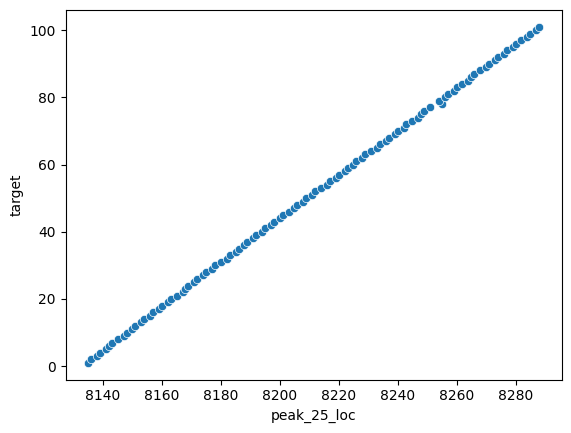

In [ ]:
sns.scatterplot(data=Si_TM_k_peaks_df, x="peak_25_loc", y="target")

In [ ]:
#Si_TM_k_peaks_df[["target","peak_4_loc"]].head(90).tail(20)

In [ ]:
#get_k_peak_loc_value(all_data["Si_TM"].iloc[76][:-1].values, k)

In [ ]:
#get_k_peak_loc_value(all_data["Si_TM"].iloc[77][:-1].values, k)

In [ ]:
#get_k_peak_loc_value(all_data["Si_TM"].iloc[78][:-1].values, k)

In [ ]:
# now do a 5-fold cross validation on the 20 peaks data
Si_TM_8_peaks_results = []
fold_i = 0
for train_index, test_index in kf.split(Si_TM_k_peaks_df):
    train_data = Si_TM_k_peaks_df.iloc[train_index]
    test_data = Si_TM_k_peaks_df.iloc[test_index]
    
    # try a Lasso model on the 20 peaks
    model = Lasso(alpha=1.5, random_state=19890417)

    # try a pls regression model on the 20 peaks
    # model = PLSRegression(n_components=8, scale=True)

    model.fit(train_data.drop(columns=["target"]), train_data["target"].values)
    # Make predictions
    y_pred = model.predict(test_data.drop(columns=["target"]))
    # Calculate MSE, R2, RMSE, MAE
    mse = mean_squared_error(test_data["target"].values, y_pred)
    r2 = r2_score(test_data["target"].values, y_pred)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(test_data["target"].values - y_pred))
    num_nonzero = np.sum(model.coef_ != 0)
    print(f"Fold {fold_i}: {num_nonzero} non-zero coefficients")
    # now calculate the same metrics on the training data
    y_train_pred = model.predict(train_data.drop(columns=["target"]))
    mse_train = mean_squared_error(train_data["target"].values, y_train_pred)
    r2_train = r2_score(train_data["target"].values, y_train_pred)
    rmse_train = np.sqrt(mse_train)
    mae_train = np.mean(np.abs(train_data["target"].values - y_train_pred))

    # Append results to the list
    Si_TM_8_peaks_results.append({
        "mse": mse,
        "r2": r2,
        "rmse": rmse,
        "mae": mae,
        "fold": fold_i,
        "mse.train": mse_train,
        "r2.train": r2_train,
        "rmse.train": rmse_train,
        "mae.train": mae_train,
    })

    fold_i += 1
Si_TM_8_peaks_result_df = pd.DataFrame(Si_TM_8_peaks_results)
Si_TM_8_peaks_result_df.agg({
    "mse": ["mean","std"],
    "r2": ["mean","std"],
    "rmse": ["mean","std"],
    "mae": ["mean","std"],
    "mse.train": ["mean","std"],
    "r2.train": ["mean","std"],
    "rmse.train": ["mean","std"],
    "mae.train": ["mean","std"],
})

Fold 0: 9 non-zero coefficients
Fold 1: 10 non-zero coefficients
Fold 2: 5 non-zero coefficients
Fold 3: 7 non-zero coefficients
Fold 4: 7 non-zero coefficients


,mse,r2,rmse,mae,mse.train,r2.train,rmse.train,mae.train
mean,0.080786,0.999894,0.271577,0.213023,0.069657,0.999917,0.263184,0.195687
std,0.055634,0.000075,0.093756,0.056298,0.011074,0.000015,0.022116,0.007321
